# Setup

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install open_clip_torch transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

In [9]:
import numpy as np
import pandas as pd
import os
import open_clip
import cv2
import matplotlib.pyplot as plt
import torch

from numpy.linalg import norm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from torchvision import transforms
from sklearn.decomposition import PCA

In [3]:
IMG_FOLDER = '/content/drive/MyDrive/SuperAI/Hackathon/Logo/train'

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k",
  device=device
)

In [5]:
class PadToSquare(object):
    def __init__(self):
        return

    def __call__(self, image):
        width, height = image.size
        l, t, r, b = 0, 0, 0, 0

        if width < height:
            lr = height - width
            if lr % 2 == 0:
                l, r = lr // 2, lr // 2
            else:
                l, r = lr // 2 + 1, lr // 2

        elif height < width:
            tb = width - height
            if tb % 2 == 0:
                t, b = tb // 2, tb // 2
            else:
                t, b = tb // 2 + 1, tb // 2
        
        padding = transforms.Pad([l, t, r, b], padding_mode='edge')
        return padding(image)

In [7]:
transform = transforms.Compose([
    PadToSquare(),
    transform
])

In [8]:
transform

Compose(
    Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f3f86464e50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
)

# Get train image embeddings

In [11]:
# # Only for first time
# train_ls = []

# for dirname, _, filenames in os.walk(IMG_FOLDER):
#     for filename in filenames:
#         if filename.endswith('.jpg'):
#             train_ls.append([
#                 os.path.join(dirname.split('/')[-1], filename),
#                 dirname.split('/')[-1]
#             ])
# train_df = pd.DataFrame(train_ls, columns=['filepath', 'class'])

In [ ]:
# train_df.to_csv('/content/drive/MyDrive/SuperAI/Logo/train.csv', index=False)

In [10]:
train_df = pd.read_csv('/content/drive/MyDrive/SuperAI/Hackathon/Logo/train.csv')

In [12]:
train_df

,filepath,class
0,144/0beec2ef-d71f-4f91-bf81-d2ba12f99bcf.jpg,144
1,145/5ece58e9-b82c-4b21-bde7-d31fea1d431e.jpg,145
2,146/f3b8f8b4-f195-4ef7-aadf-ed27575fc218.jpg,146
3,147/783e6adc-7fc2-4dc8-b15a-ff9792b476d5.jpg,147
4,149/88913fdc-42f4-4c93-8970-477fe7644c15.jpg,149
...,...,...
2373,14/2eafbfe0-0ba8-458a-98b9-31d072c402c1.jpg,14
2374,140/958ace24-419b-44e3-8f68-804957ee19d8.jpg,140
2375,141/c902bf86-a1f8-44ed-b0da-f02319470e1d.jpg,141
2376,142/e6cbfbbf-50e6-4e76-a805-a5dde4f5d713.jpg,142


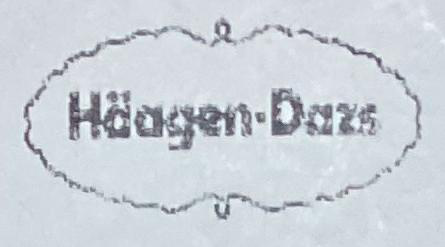

In [13]:
Image.open(os.path.join(IMG_FOLDER, train_df.iloc[0]['filepath'])).convert("RGB")

In [14]:
class LogoDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.transform(Image.open(os.path.join(IMG_FOLDER, self.df.iloc[idx]['filepath'])).convert("RGB"))

In [15]:
train_ds = LogoDataset(train_df, transform)

train_loader = DataLoader(train_ds, batch_size=64)

In [16]:
train_ds[0].shape

torch.Size([3, 224, 224])

In [17]:
embs = []
running_vloss = 0

with torch.no_grad():
    for inputs in tqdm(train_loader):
        inputs = inputs.to(device)
        outputs = model.encode_image(inputs)

        embs.append(outputs.detach().cpu().numpy())

100%|██████████| 38/38 [18:47<00:00, 29.68s/it]


In [18]:
out_embs = np.concatenate(embs)

In [19]:
train_emb_df = train_df.copy()
train_emb_df['emb'] = list(out_embs)

In [20]:
train_emb_df

,filepath,class,emb
0,144/0beec2ef-d71f-4f91-bf81-d2ba12f99bcf.jpg,144,"[0.007827357, -0.018494971, -0.017536486, -0.0..."
1,145/5ece58e9-b82c-4b21-bde7-d31fea1d431e.jpg,145,"[-0.009952992, 0.03892397, -0.04668272, -0.019..."
2,146/f3b8f8b4-f195-4ef7-aadf-ed27575fc218.jpg,146,"[-0.0027443487, 0.01291093, 0.013630984, -0.04..."
3,147/783e6adc-7fc2-4dc8-b15a-ff9792b476d5.jpg,147,"[0.053191327, -0.01592388, 0.006094165, -0.047..."
4,149/88913fdc-42f4-4c93-8970-477fe7644c15.jpg,149,"[-0.005376611, 0.016145304, -0.0145950755, -0...."
...,...,...,...
2373,14/2eafbfe0-0ba8-458a-98b9-31d072c402c1.jpg,14,"[-0.0289384, -0.00053107436, -0.01761771, 0.00..."
2374,140/958ace24-419b-44e3-8f68-804957ee19d8.jpg,140,"[-0.034674257, -0.024730446, 0.023535319, -0.0..."
2375,141/c902bf86-a1f8-44ed-b0da-f02319470e1d.jpg,141,"[0.010649022, -0.030666677, -0.03454667, -0.02..."
2376,142/e6cbfbbf-50e6-4e76-a805-a5dde4f5d713.jpg,142,"[-0.014933354, 0.030582722, 0.039794665, -0.01..."


In [21]:
torch.save(out_embs, '/content/drive/MyDrive/SuperAI/Hackathon/Logo/train_coca.pt')

# Work with the embeddings

In [22]:
out_embs = torch.load('/content/drive/MyDrive/SuperAI/Hackathon/Logo/train_coca.pt')
train_emb_df = train_df.copy()
train_emb_df['emb'] = list(out_embs)

In [24]:
train_emb_df

,filepath,class,emb
0,144/0beec2ef-d71f-4f91-bf81-d2ba12f99bcf.jpg,144,"[0.007827357, -0.018494971, -0.017536486, -0.0..."
1,145/5ece58e9-b82c-4b21-bde7-d31fea1d431e.jpg,145,"[-0.009952992, 0.03892397, -0.04668272, -0.019..."
2,146/f3b8f8b4-f195-4ef7-aadf-ed27575fc218.jpg,146,"[-0.0027443487, 0.01291093, 0.013630984, -0.04..."
3,147/783e6adc-7fc2-4dc8-b15a-ff9792b476d5.jpg,147,"[0.053191327, -0.01592388, 0.006094165, -0.047..."
4,149/88913fdc-42f4-4c93-8970-477fe7644c15.jpg,149,"[-0.005376611, 0.016145304, -0.0145950755, -0...."
...,...,...,...
2373,14/2eafbfe0-0ba8-458a-98b9-31d072c402c1.jpg,14,"[-0.0289384, -0.00053107436, -0.01761771, 0.00..."
2374,140/958ace24-419b-44e3-8f68-804957ee19d8.jpg,140,"[-0.034674257, -0.024730446, 0.023535319, -0.0..."
2375,141/c902bf86-a1f8-44ed-b0da-f02319470e1d.jpg,141,"[0.010649022, -0.030666677, -0.03454667, -0.02..."
2376,142/e6cbfbbf-50e6-4e76-a805-a5dde4f5d713.jpg,142,"[-0.014933354, 0.030582722, 0.039794665, -0.01..."


In [25]:
train_emb_df.value_counts('class')

class
b                  123
hp                  87
Domino's Pizza      87
Kodak               83
Hewlett-Packard     77
                  ... 
178                  1
177                  1
176                  1
175                  1
187                  1
Length: 173, dtype: int64

# Evaluate

## Repeat

In [39]:
import warnings
warnings.filterwarnings('ignore')

scores = []

thres = 0.8
class_df = train_df.value_counts('class').rename_axis('class').reset_index(name='count')
classes = class_df[class_df['count'] > 2]['class']

for r in tqdm(range(50)):
    query_df = pd.DataFrame([], columns=['filepath', 'class', 'emb'])
    for cl in classes:
        df = train_emb_df[train_emb_df['class'] == cl]
        query_df = query_df.append(df.sample(n=1, random_state=r))
    data_df = train_emb_df[~train_emb_df['filepath'].isin(query_df['filepath'])]
    data_df['label'] = data_df['class'].apply(lambda x: x if x in list(classes) else 'Others')

    data_emb = np.stack(data_df['emb'])
    query_emb = np.stack(query_df['emb'])

    result = cosine_similarity(data_emb, query_emb)
    result_idx = result.argmax(axis=1)
    result_idx[result.max(axis=1) < thres] = -1

    pred = []
    for idx in result_idx:
        if idx == -1:
            pred.append('Others')
        else:
            pred.append(query_df.iloc[idx]['class'])
    data_df['pred'] = pred

    scores.append(f1_score(data_df['label'], data_df['pred'], average='macro'))

print()
print(np.mean(scores))

100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


0.8446828202880406


## Alternative

In [ ]:
data_df = data_df[['filepath', 'emb']]

In [ ]:
data_df

,filepath,emb
0,a807c820-e717-4ad9-890f-64e25dde7a4f.jpg,"[0.0033500346, 0.054122567, -0.03718847, -0.01..."
1,4a90506e-5b85-480c-bc58-9b14536bcb66.jpg,"[-0.008755614, 0.045869585, -0.0400058, -0.015..."
2,84a652a1-61a0-486d-b71e-31b6a1053c3e.jpg,"[0.015030686, 0.028568292, -0.056674108, 0.019..."
3,9d501102-121e-42ba-911f-b79b9b60c7cc.jpg,"[-0.020664262, 0.022946756, -0.019618629, -0.0..."
4,913bd600-d0d4-4a3a-b7d5-6b3aaeac0bb5.jpg,"[-0.0032748056, 0.045254424, -0.034904446, -0...."
...,...,...
1115,7c8f9a39-3f5f-4512-b905-208058e63ff4.jpg,"[-0.042138774, 0.015996313, -0.02826418, -0.01..."
1116,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[0.02553618, -0.015780041, -0.008833275, -0.04..."
1117,c2e9f4ed-7640-4def-8d08-317516a71c88.jpg,"[0.017505176, 0.023614276, -0.010742046, -0.02..."
1118,8ef08006-ce13-4f21-b976-7a6f2a93459d.jpg,"[-0.025152536, 0.055744596, -0.034649286, 0.01..."


In [ ]:
query_df

,filepath,emb
0,20.jpg,"[-0.005651356, 0.045122374, -0.03385142, -0.02..."
1,6.jpg,"[0.0027399126, 0.0041315993, -0.0010481392, -0..."
2,5.jpg,"[0.010830615, 0.013762646, 0.008017133, -0.027..."
3,8.jpg,"[0.00035146225, 0.0120935235, 0.013817953, -0...."
4,10.jpg,"[-0.009613819, 0.014511539, -0.0048018256, 0.0..."
5,0.jpg,"[0.0065318295, 0.027243476, 0.014111515, -0.03..."
6,9.jpg,"[0.028592955, 0.033815846, -0.03878431, -0.003..."
7,1.jpg,"[-0.046500307, 0.019312855, -0.03146047, -0.00..."
8,16.jpg,"[0.006931016, 0.023089634, 0.017921412, -0.001..."
9,7.jpg,"[-0.005095755, -0.013485303, -0.037325867, -0...."


In [ ]:
result = cosine_similarity(query_emb, data_emb)
result.shape

(22, 1120)

In [ ]:
data_df['pred'] = '22.jpg'
data_df['max'] = 0

In [ ]:
data_df

,filepath,emb,pred,max
0,a807c820-e717-4ad9-890f-64e25dde7a4f.jpg,"[0.0033500346, 0.054122567, -0.03718847, -0.01...",22.jpg,0
1,4a90506e-5b85-480c-bc58-9b14536bcb66.jpg,"[-0.008755614, 0.045869585, -0.0400058, -0.015...",22.jpg,0
2,84a652a1-61a0-486d-b71e-31b6a1053c3e.jpg,"[0.015030686, 0.028568292, -0.056674108, 0.019...",22.jpg,0
3,9d501102-121e-42ba-911f-b79b9b60c7cc.jpg,"[-0.020664262, 0.022946756, -0.019618629, -0.0...",22.jpg,0
4,913bd600-d0d4-4a3a-b7d5-6b3aaeac0bb5.jpg,"[-0.0032748056, 0.045254424, -0.034904446, -0....",22.jpg,0
...,...,...,...,...
1115,7c8f9a39-3f5f-4512-b905-208058e63ff4.jpg,"[-0.042138774, 0.015996313, -0.02826418, -0.01...",22.jpg,0
1116,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[0.02553618, -0.015780041, -0.008833275, -0.04...",22.jpg,0
1117,c2e9f4ed-7640-4def-8d08-317516a71c88.jpg,"[0.017505176, 0.023614276, -0.010742046, -0.02...",22.jpg,0
1118,8ef08006-ce13-4f21-b976-7a6f2a93459d.jpg,"[-0.025152536, 0.055744596, -0.034649286, 0.01...",22.jpg,0


In [ ]:
thres = 0.8

for i in tqdm(range(len(result))):
    pred = query_df.iloc[i]['filepath']
    new_max = np.where(result[i] > thres, result[i], 0)
    max = data_df['max']
    data_df['pred'] = data_df['pred'].where(new_max <= max, pred)
    data_df['max'] = data_df['max'].where(new_max <= max, new_max)

100%|██████████| 22/22 [00:00<00:00, 457.16it/s]


In [ ]:
data_df

,filepath,emb,pred,max
0,a807c820-e717-4ad9-890f-64e25dde7a4f.jpg,"[0.0033500346, 0.054122567, -0.03718847, -0.01...",20.jpg,0.969453
1,4a90506e-5b85-480c-bc58-9b14536bcb66.jpg,"[-0.008755614, 0.045869585, -0.0400058, -0.015...",20.jpg,0.992982
2,84a652a1-61a0-486d-b71e-31b6a1053c3e.jpg,"[0.015030686, 0.028568292, -0.056674108, 0.019...",22.jpg,0.000000
3,9d501102-121e-42ba-911f-b79b9b60c7cc.jpg,"[-0.020664262, 0.022946756, -0.019618629, -0.0...",20.jpg,0.815350
4,913bd600-d0d4-4a3a-b7d5-6b3aaeac0bb5.jpg,"[-0.0032748056, 0.045254424, -0.034904446, -0....",20.jpg,0.997418
...,...,...,...,...
1115,7c8f9a39-3f5f-4512-b905-208058e63ff4.jpg,"[-0.042138774, 0.015996313, -0.02826418, -0.01...",1.jpg,0.984191
1116,7e548b62-5c95-478e-b61f-7a6fb0cd631b.jpg,"[0.02553618, -0.015780041, -0.008833275, -0.04...",22.jpg,0.000000
1117,c2e9f4ed-7640-4def-8d08-317516a71c88.jpg,"[0.017505176, 0.023614276, -0.010742046, -0.02...",14.jpg,0.983253
1118,8ef08006-ce13-4f21-b976-7a6f2a93459d.jpg,"[-0.025152536, 0.055744596, -0.034649286, 0.01...",20.jpg,0.953570


In [ ]:
f1_score(data_df['label'], data_df['pred'], average='macro')

0.9023412090559108